In [1]:
import numpy as np
import pandas as pd
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.express import colors

from Readers.SQLiteReader import SQLiteReader
from Readers.dataframe_reader import DataFrameReader

from Formatters.OHLCVFormatter import OHLCVFormatter
from Formatters.ArticleFormatter import ArticleFormatter

In [2]:
# Conexion con la df
dbReader = SQLiteReader()
dbReader.connect("../news_analyzer2.db")

articles = dbReader.read("SELECT * FROM articles")
article_formatter = ArticleFormatter()
articles = article_formatter.format(articles)
df_articles = article_formatter.ListToDF(articles)
print(f'Antes hay {df_articles.shape[0]} articulos')

df_clean = article_formatter.only_englishnews(df_articles)
print(f'Antes hay {df_clean.shape[0]} articulos')

df_sum = article_formatter.ResampleDF(df_clean[['sentiment']], '1D')
df_sum['rolling_mean_sentiment'] = df_sum['sentiment'].rolling(7).mean()
df_sum['rolling_std_sentiment'] = df_sum['sentiment'].rolling(7).std()
df_sum.dropna(inplace=True)

df_sum.tail()

Antes hay 41385 articulos
Antes hay 40451 articulos


,sentiment,rolling_mean_sentiment,rolling_std_sentiment
datetime,,,
2023-11-27,9.1049,5.185586,4.979931
2023-11-28,8.4440,4.417957,3.669299
2023-11-29,12.0358,5.280271,4.674529
2023-11-30,14.1033,6.761814,5.644951
2023-12-01,7.0387,7.246671,5.475817


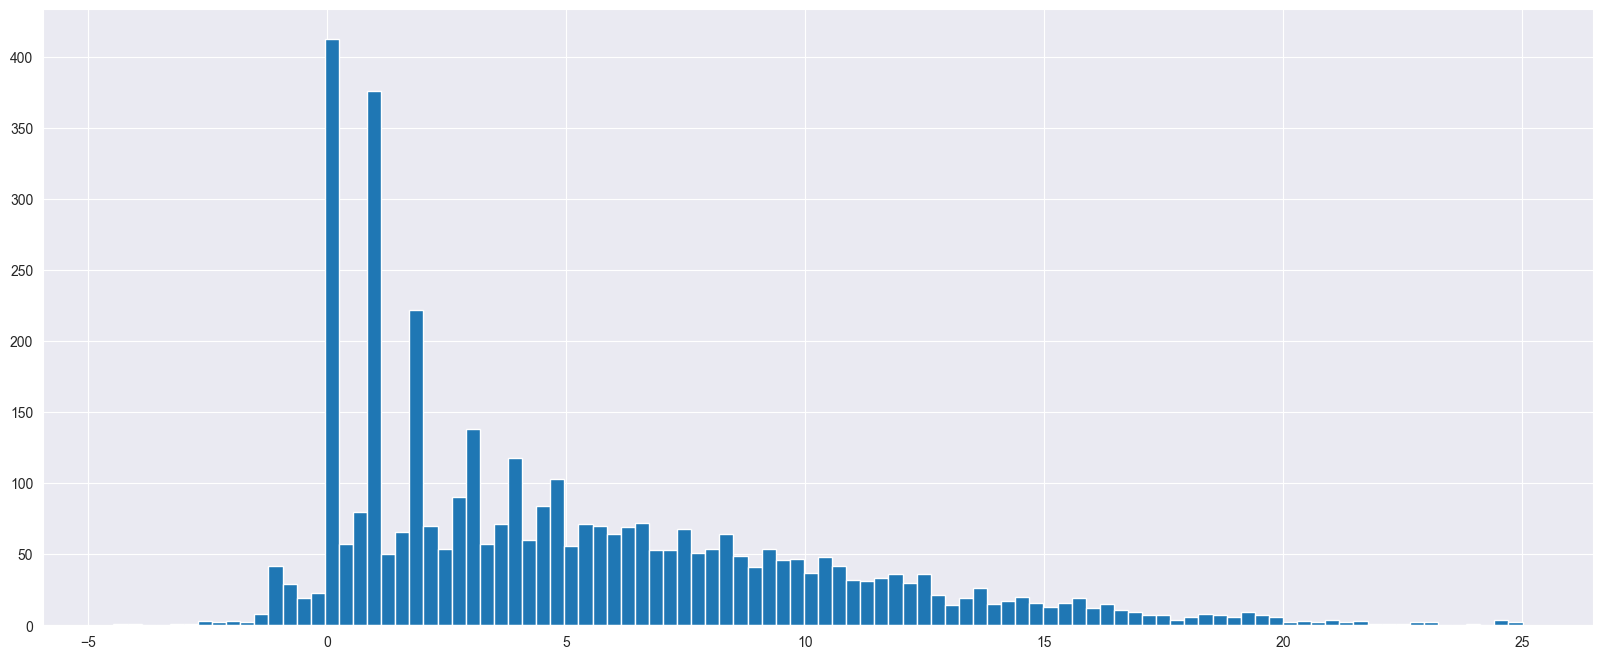

In [3]:
# Histograma del sentimiento
plt.figure(figsize=(20,8))
plt.hist(df_sum['sentiment'], bins=100)
plt.show()

In [4]:
# Guardar el .csv de las noticias nuevas
path = "../data/news_analyzer_clean.csv"
df_clean.to_csv(path)

In [5]:
# Cargar las cotizaciones
path_ohlcv = "../data/BTCUSD.csv"
ohlcv_formatter = OHLCVFormatter()
df_reader = DataFrameReader(path_ohlcv)
df_reader.read()
df_ohlcv = df_reader.format(ohlcv_formatter.format)
df_ohlcv['log_returns'] = np.log( df_ohlcv['close']/df_ohlcv['close'].shift(1))
df_ohlcv['rolling_mean_close'] = df_ohlcv['close'].rolling(7).mean()
df_ohlcv['rolling_std_close'] = df_ohlcv['close'].rolling(7).std()
df_ohlcv.dropna(inplace=True)  # Pasa lo mismo que con df_sum

df_ohlcv.tail()

,open,high,low,close,volume,log_returns,rolling_mean_close,rolling_std_close
datetime,,,,,,,,
2023-11-30,37870.85,38148.48,37513.42,37728.97,0.0,-0.003754,37666.755714,223.921984
2023-12-01,37727.75,38983.54,37622.28,38688.85,0.0,0.025123,37805.464286,448.744149
2023-12-02,38688.85,39717.12,38659.66,39471.17,0.0,0.020019,38042.805714,773.355038
2023-12-03,39471.04,40203.62,39292.85,39988.27,0.0,0.013016,38403.154286,1010.894056
2023-12-04,39988.18,41801.88,39986.31,41695.08,0.0,0.041797,39037.345714,1462.661088


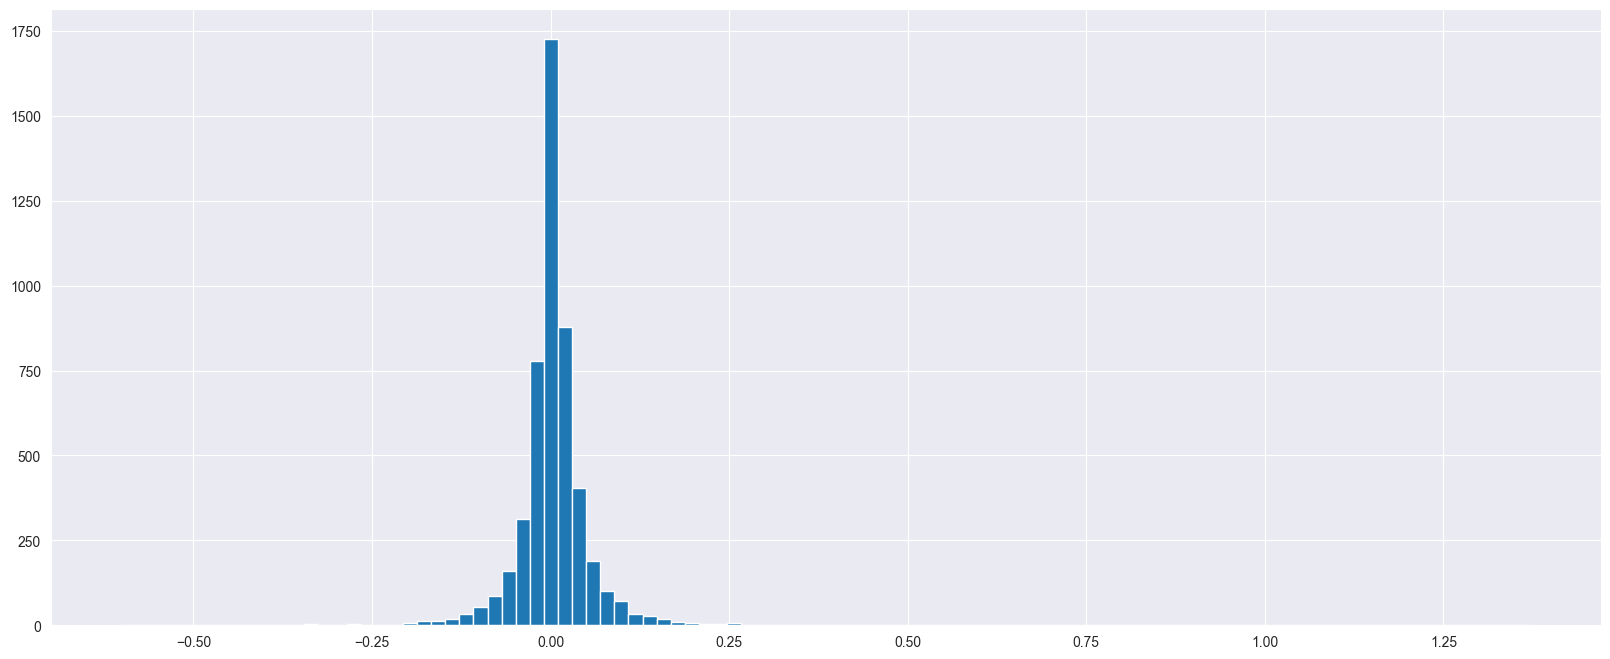

In [6]:
# Histograma de los retornos
plt.figure(figsize=(20,8))
plt.hist(df_ohlcv['log_returns'], bins=100)
plt.show()

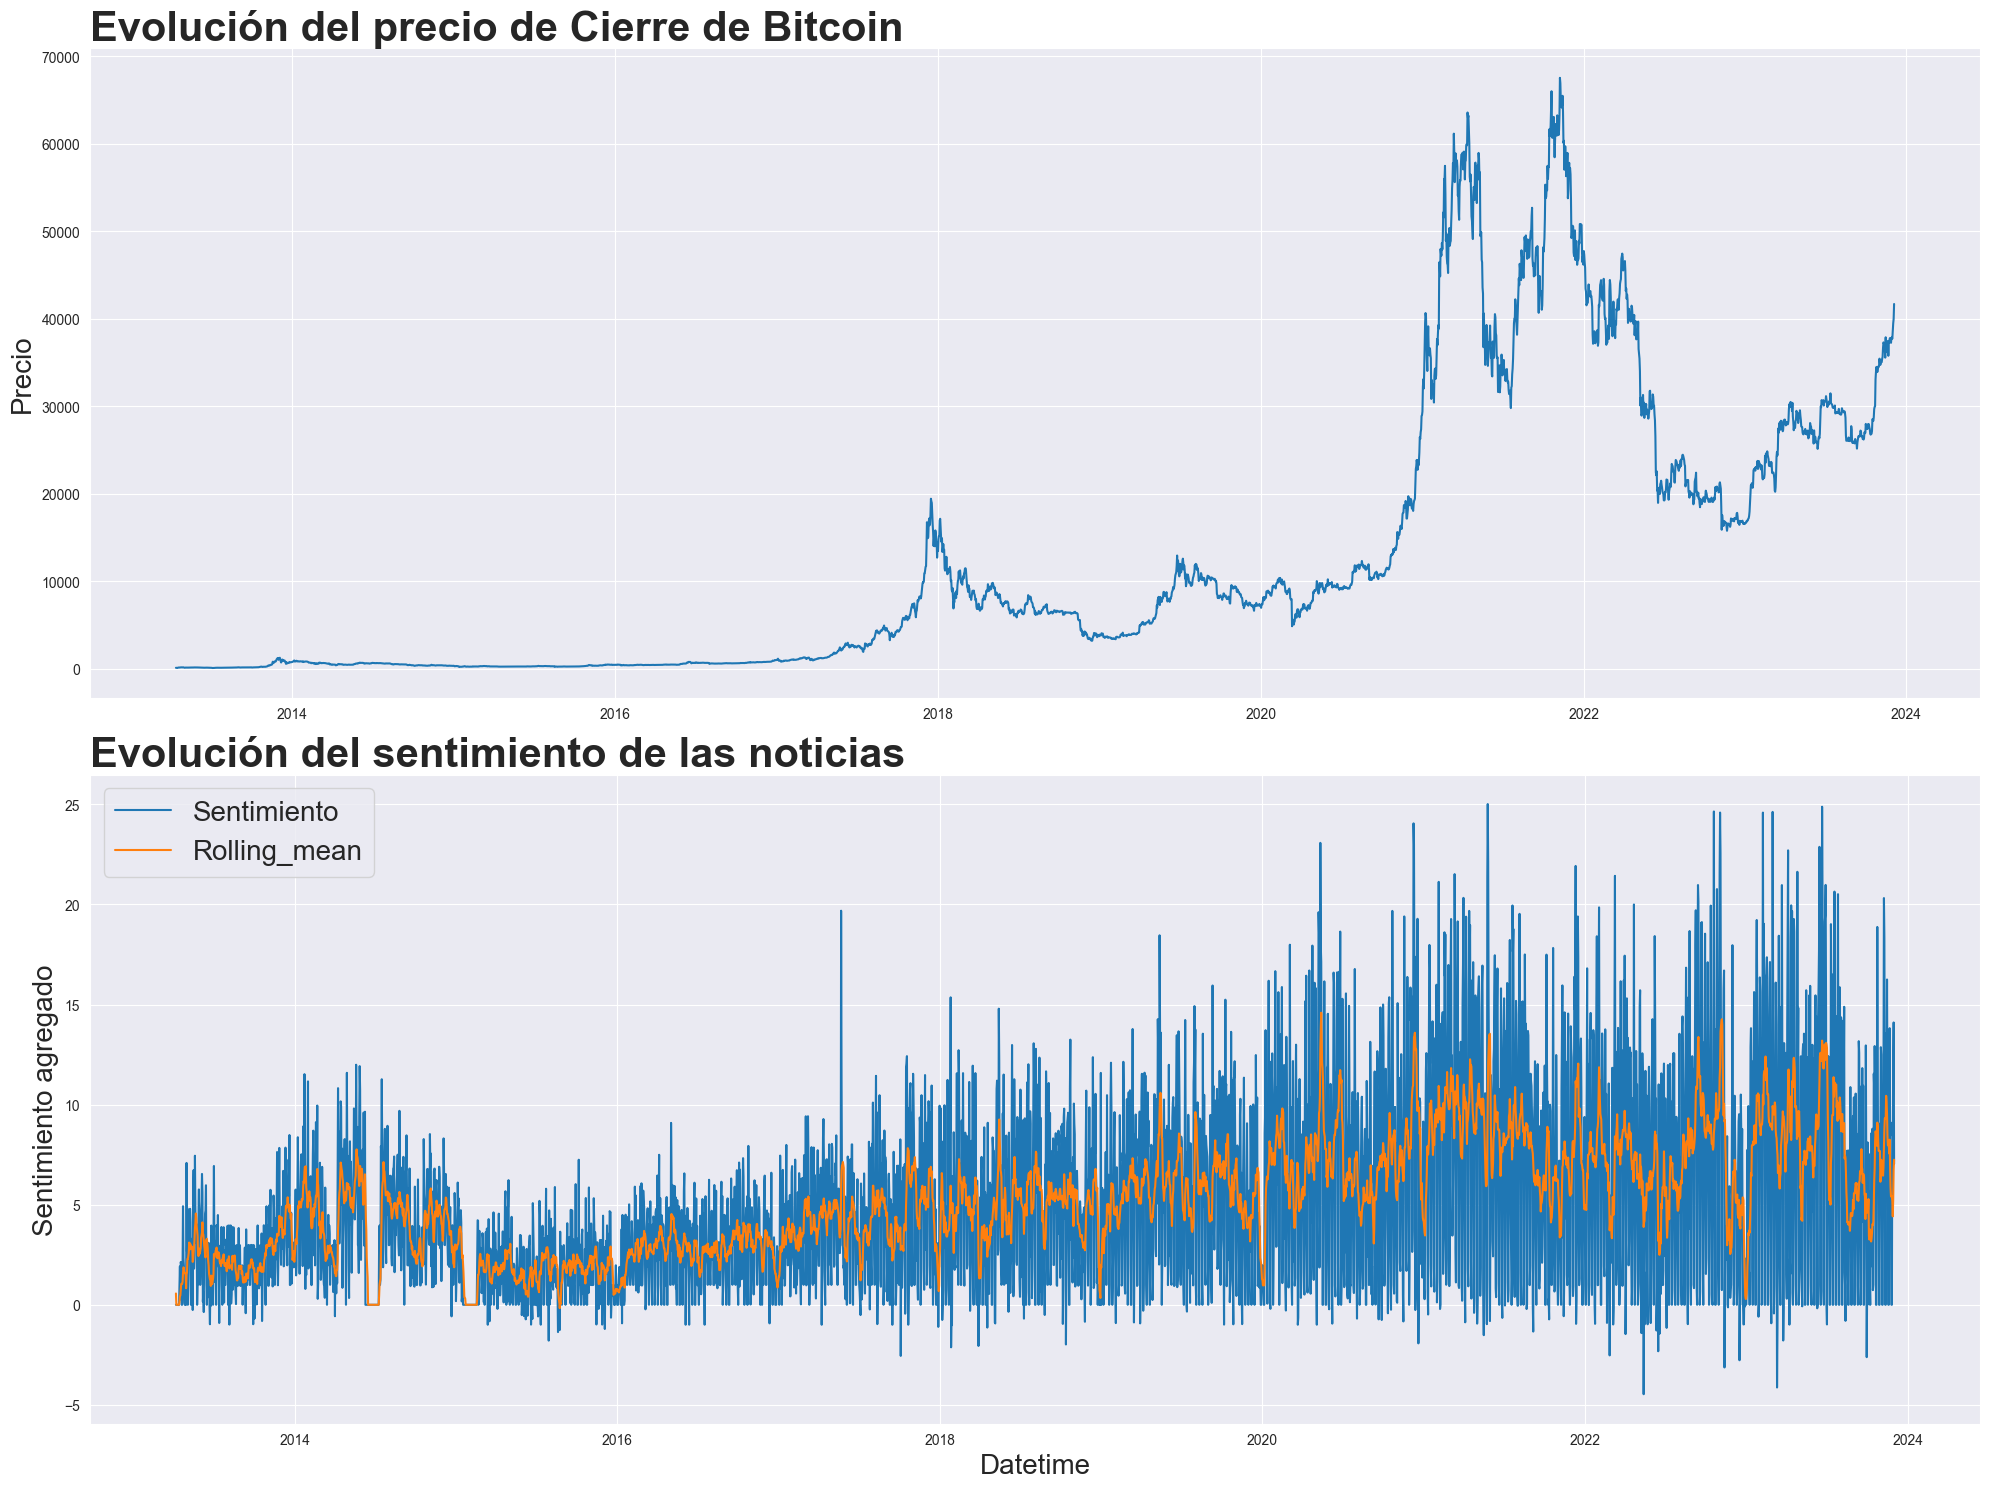

In [7]:
# Representar subplot cotizacion, sentimiento
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

ax[0].plot(df_ohlcv.loc['2013-04-13':, 'close'])
ax[0].set_ylabel('Precio', fontsize=20)
ax[0].set_title('Evolución del precio de Cierre de Bitcoin', fontsize=30, fontweight='bold', loc='left')

ax[1].plot(df_sum['sentiment'], label='Sentimiento')
ax[1].plot(df_sum['rolling_mean_sentiment'], label='Rolling_mean')
ax[1].set_xlabel('Datetime', fontsize=20)
ax[1].set_ylabel('Sentimiento agregado', fontsize=20)
ax[1].set_title('Evolución del sentimiento de las noticias', fontsize=30, fontweight='bold', loc='left')
ax[1].legend(fontsize=20)

plt.tight_layout()
plt.show()

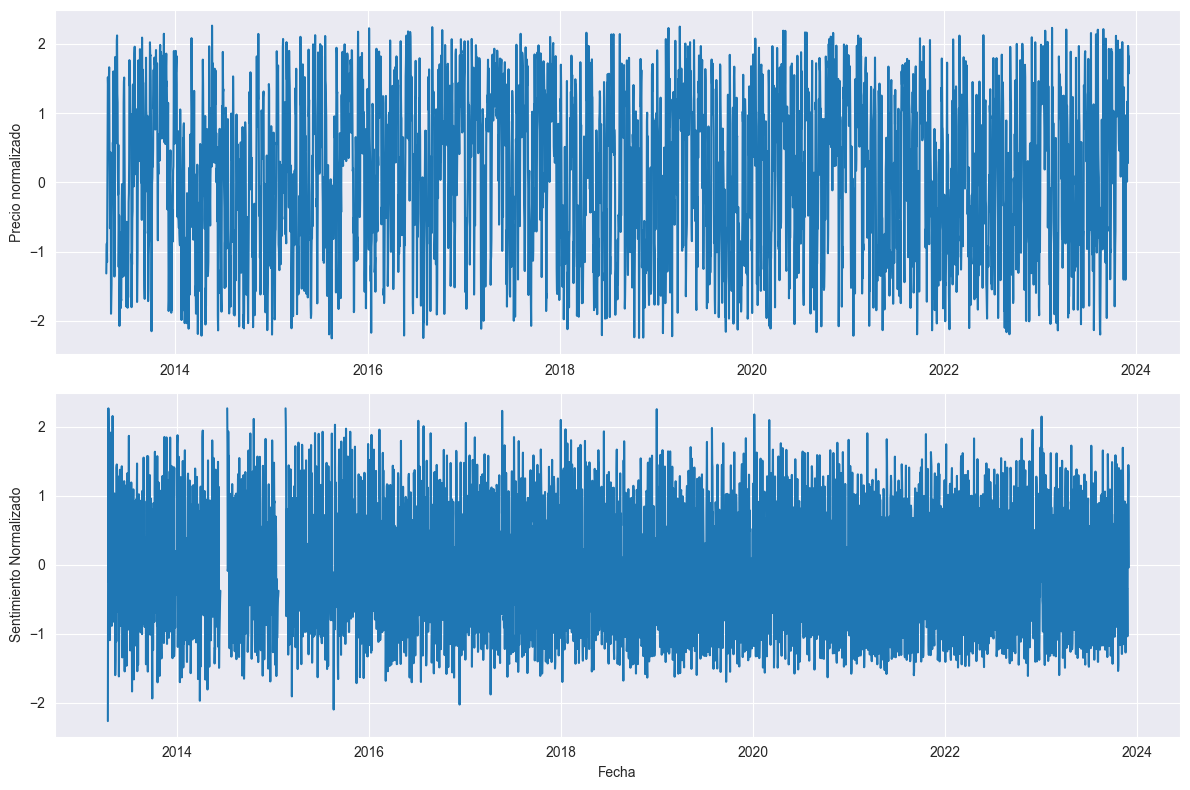

In [8]:
# Veamos la comparación entre z_score del precio y del sentimiento
df_sum['rolling_zscore_sentiment'] = ((df_sum['sentiment'] - df_sum['rolling_mean_sentiment'])
                                      /df_sum['rolling_std_sentiment'])

df_ohlcv['rolling_zscore_close'] = ((df_ohlcv['close'] - df_ohlcv['rolling_mean_close'])
                                      /df_ohlcv['rolling_std_close'])
                 
                                      
# Representar
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(df_ohlcv.loc['2013-04-13':, 'rolling_zscore_close'])
ax[0].set_ylabel('Precio normalizado')

ax[1].plot(df_sum['rolling_zscore_sentiment'])
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Sentimiento Normalizado')

plt.tight_layout()
plt.show()

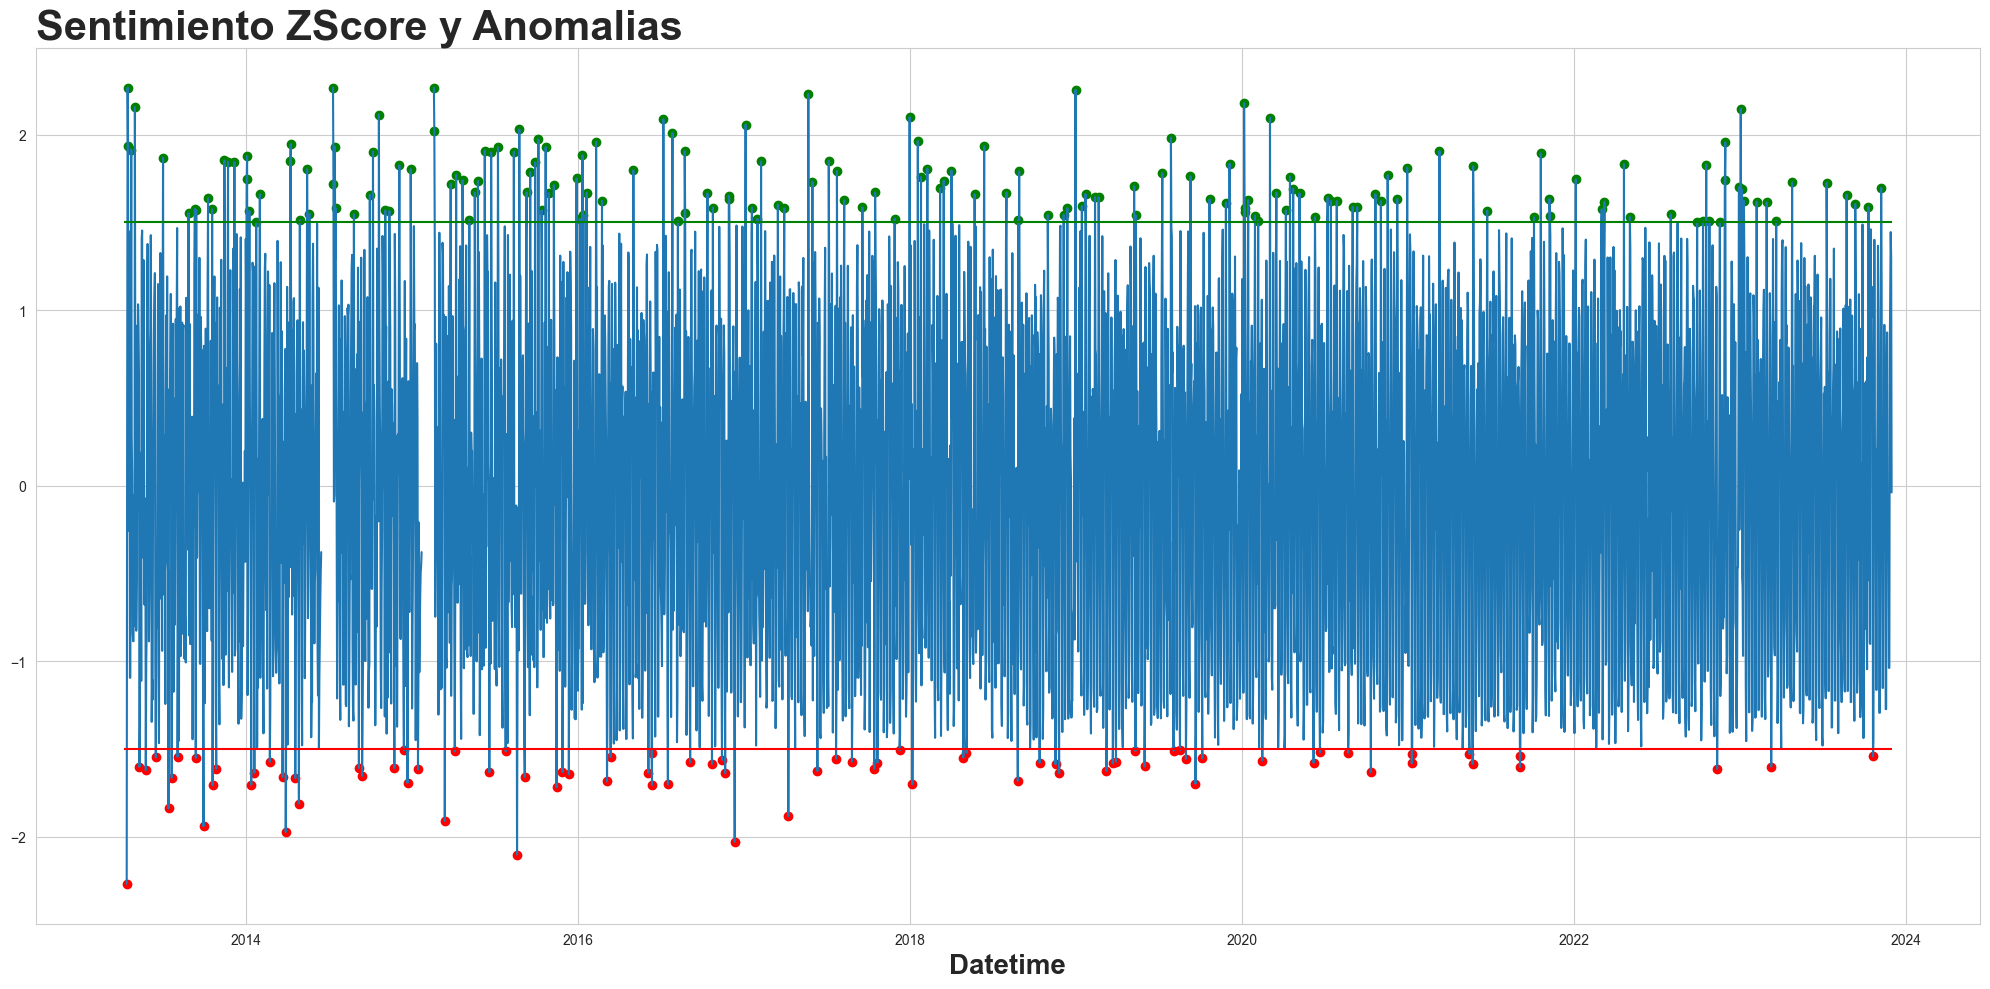

In [9]:
# Calcular las anomalias positivas y negativas
threshold = 1.5
mask_anomalias_positivas = df_sum['rolling_zscore_sentiment'] > threshold
mask_anomalias_negativas = df_sum['rolling_zscore_sentiment'] < -threshold

anomalias_positivas = df_sum.loc[mask_anomalias_positivas, 'rolling_zscore_sentiment']
anomalias_negativas = df_sum.loc[mask_anomalias_negativas, 'rolling_zscore_sentiment']

df_sum['positive_anomalie_index'] = df_sum['rolling_zscore_sentiment'].apply(lambda x: 1 if x > threshold else 0)
df_sum['negative_anomalie_index'] = df_sum['rolling_zscore_sentiment'].apply(lambda x: 1 if x < -threshold else 0)

# Representar las anomalias de precio
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))

plt.plot(df_sum['rolling_zscore_sentiment'], label='zscore_sentiment')
plt.scatter(anomalias_positivas.index, anomalias_positivas, color='g')
plt.scatter(anomalias_negativas.index, anomalias_negativas, color='r')
plt.hlines(threshold, df_sum['rolling_zscore_sentiment'].index[0], 
           df_sum['rolling_zscore_sentiment'].index[-1],color='g')
plt.hlines(-threshold, df_sum['rolling_zscore_sentiment'].index[0], 
           df_sum['rolling_zscore_sentiment'].index[-1],color='r')


plt.xlabel('Datetime', fontweight='bold', fontsize=20)
plt.title('Sentimiento ZScore y Anomalias', loc='left', fontweight='bold', fontsize=30)

plt.tight_layout()
plt.show()

In [10]:
# Vamos a calcular la media y la desviacion tipica del Zscore del sentiment para ver como ajustar el threshold
media = df_sum['rolling_zscore_sentiment'].mean()
desvesta = df_sum['rolling_zscore_sentiment'].std()
print('Media de Zscore = {}'.format(media))
print('Desviación Típica de Zscore = {}'.format(desvesta))
print('El threshold sería = {}'.format(media+desvesta))

Media de Zscore = 0.004923580799080212
Desviación Típica de Zscore = 0.9370241610187758
El threshold sería = 0.941947741817856


# Correlación entre zscore sentiment y zscore close

Cotizaciones tiene 3622 valores
Sentimiento tiene 3622 valores
La correlación entre Logreturns y el Sentimiento = 0.049348977296962256


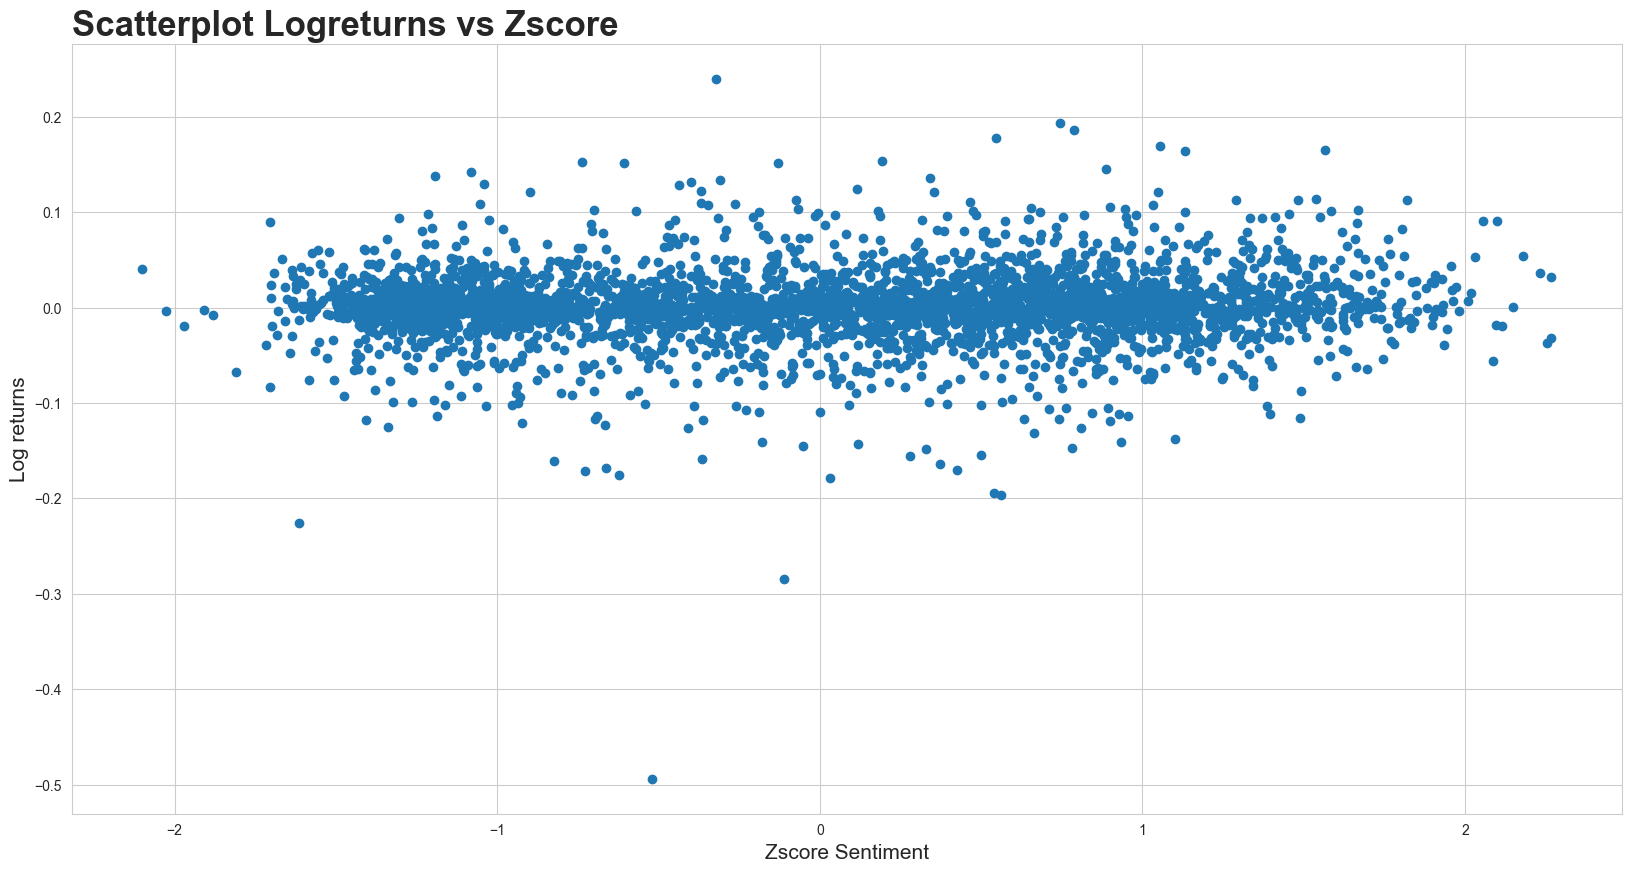

In [11]:
# Creamos un df conjunto desde la primera fecha
# ini_fecha = df_sum.index[0]
ini_fecha = '2014-01-01'
ini_final = df_ohlcv.index[df_ohlcv.shape[0]-4]
cotizaciones = df_ohlcv.loc[ini_fecha:ini_final, 'log_returns']
sentimiento = df_sum.loc[ini_fecha:, 'rolling_zscore_sentiment']

print(f'Cotizaciones tiene {len(cotizaciones)} valores')
print(f'Sentimiento tiene {len(sentimiento)} valores')

print(f'La correlación entre Logreturns y el Sentimiento = {cotizaciones.corr(sentimiento)}')

# Scatter plot
plt.figure(figsize=(20,10))
plt.scatter(sentimiento, cotizaciones)
plt.xlabel('Zscore Sentiment', fontsize=15)
plt.ylabel('Log returns', fontsize=15)
plt.title('Scatterplot Logreturns vs Zscore', fontsize=25, fontweight='bold', loc='left')
plt.show()

No hemos tenido una correlación muy alta entre las variables de manera directa veamos si los retornos a dias posteriores 1 o 7 días son mejores en cuanto a correlación y resultados

# ¿Las noticias de hoy explican los retornos de mañana?

In [12]:
# Ahora veremos la correlación directa entre las variables
ini_fecha = '2014-01-01'
ini_final = df_ohlcv.index[df_ohlcv.shape[0]-4]
cotizaciones = df_ohlcv.loc[ini_fecha:ini_final, 'log_returns']
sentimiento = df_sum.loc[ini_fecha:, 'rolling_zscore_sentiment']

print(f'Cotizaciones tiene {len(cotizaciones)} valores')
print(f'Sentimiento tiene {len(sentimiento)} valores')

print(f'La correlación entre Logreturns desfasado 1 dia y el Sentimiento = {cotizaciones.shift(1).corr(sentimiento)}')
print(f'La correlación entre Logreturns desfasado 7 dias y el Sentimiento = {cotizaciones.shift(7).corr(sentimiento)}')

Cotizaciones tiene 3622 valores
Sentimiento tiene 3622 valores
La correlación entre Logreturns desfasado 1 dia y el Sentimiento = 0.04039516909670457
La correlación entre Logreturns desfasado 7 dias y el Sentimiento = -0.014877655278194483


No parece que mejore el resultado, veamos en el caso de que ocurra una anomalia

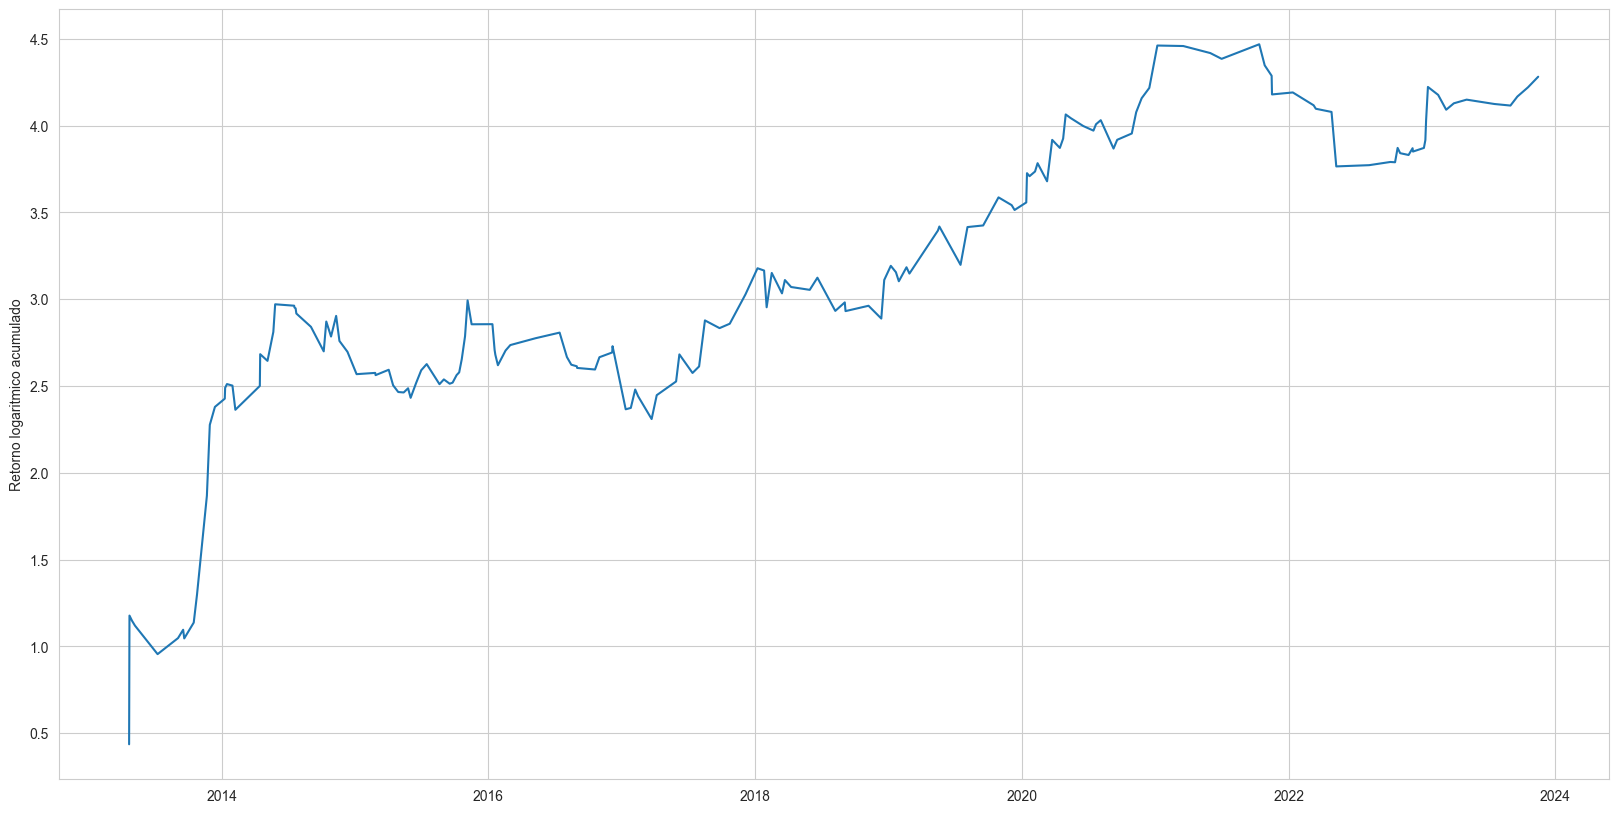

In [13]:
return_anomaly_positive = []
index_fechas = []
for anomaly in anomalias_positivas.index:
    aux = sum(df_ohlcv.loc[(anomaly + pd.Timedelta(days=1)):(anomaly + pd.Timedelta(days=7)), 'log_returns'])
    return_anomaly_positive.append(aux)
    index_fechas.append(anomaly + pd.Timedelta(days=7))

# Convertimos a acumulado
return_anomaly_positive = pd.Series(return_anomaly_positive)
return_anomaly_positive = return_anomaly_positive.cumsum()

# Representamos el retorno en si 
plt.figure(figsize=(20, 10))
plt.plot(index_fechas, return_anomaly_positive)
plt.ylabel('Retorno logaritmico acumulado')
plt.show()

Mejora mucho las puntuaciones pero no mejora el caso del Hold

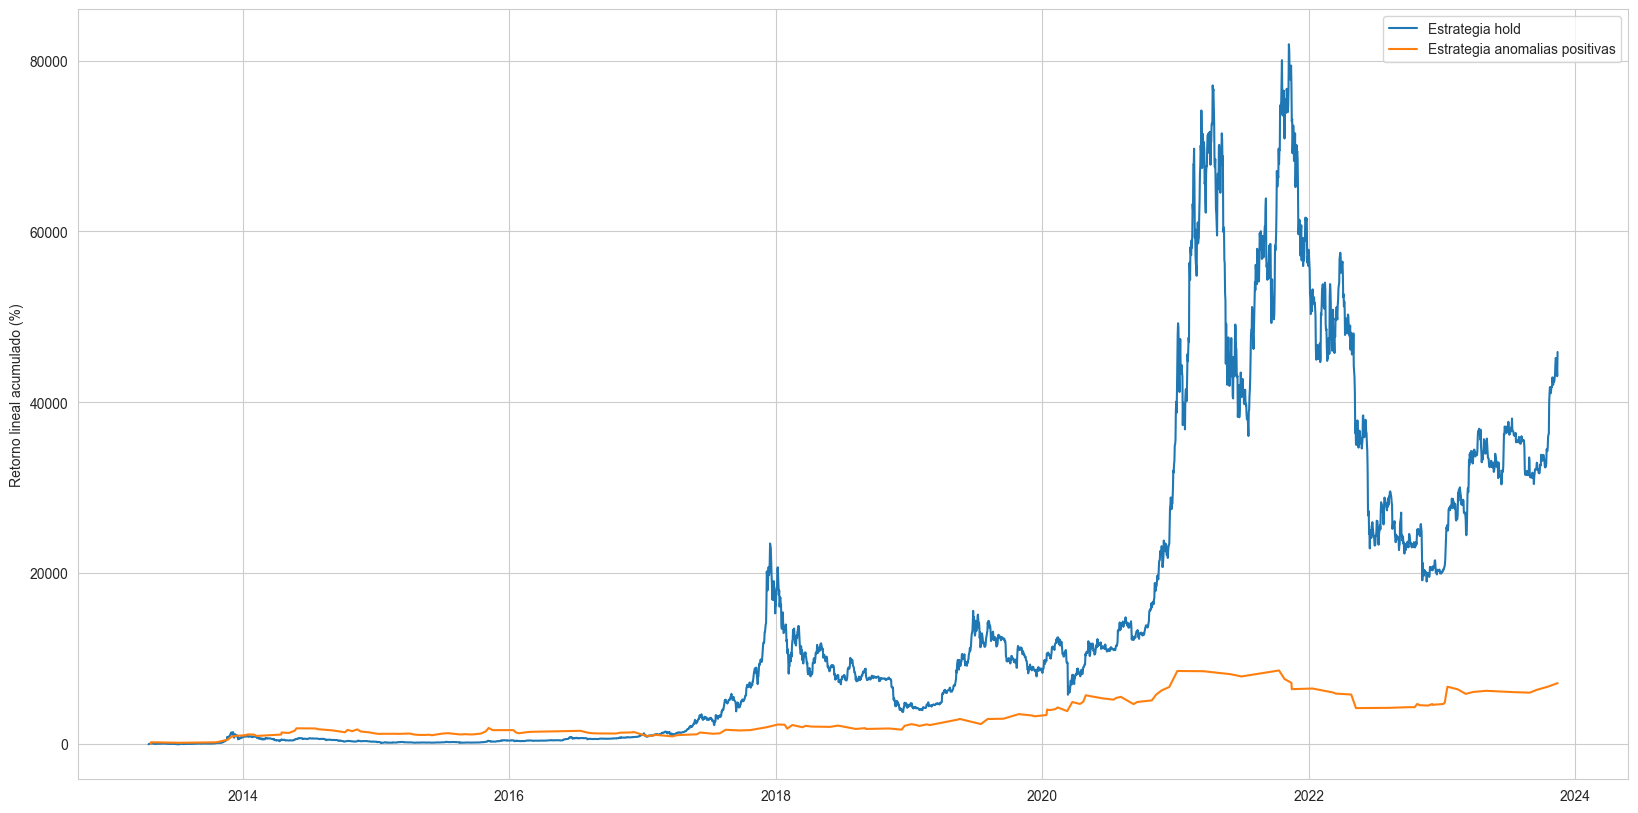

In [14]:
return_anomaly_positive_lineal = (np.exp(return_anomaly_positive) - 1.0) * 100

# Calcular los retornos de hold
index_ini = anomalias_positivas.index[0] + pd.Timedelta(days=1)
index_fin = anomalias_positivas.index[len(anomalias_positivas)-1] + pd.Timedelta(days=7)
retornos_hold = df_ohlcv.loc[index_ini:index_fin,'log_returns']

# Volver retorno acumulado
retornos_hold = retornos_hold.cumsum()
retornos_hold_lineal = (np.exp(retornos_hold) - 1.0) * 100

# Representamos el retorno de hold y de las noticias
plt.figure(figsize=(20, 10))
plt.plot(retornos_hold_lineal, label='Estrategia hold')
plt.plot(index_fechas, return_anomaly_positive_lineal, label='Estrategia anomalias positivas')
plt.legend()
plt.ylabel('Retorno lineal acumulado (%)')
plt.show()

# ¿Los autores tienen un sentimiento sesgado?

In [15]:
# Vamos a ver cuantos autores tenemos
autores = np.unique(df_clean['author'])
print(f'Hay {len(autores)} autores distintos')

Hay 423 autores distintos


 Deirdra  Funcheon, sentimiento = 0.36+-0.68
Aaron Stanley, sentimiento = 0.03+-0.18
Aaron van Wirdum, sentimiento = 0.08+-0.32
Ada Hui, sentimiento = 0.01+-0.15
Adam B. Levine, sentimiento = 0.15+-0.46
Adam Draper, sentimiento = 1.00+-nan
Adam Hanft, sentimiento = 1.00+-nan
Adam Hart, sentimiento = 1.00+-nan
Adam Krellenstein, sentimiento = 1.00+-nan
Adam Ludwin, sentimiento = 0.94+-nan
Aditi Hudli, sentimiento = 0.15+-0.41
Alex Brokaw, sentimiento = 0.99+-0.01
Alex Sunnarborg, sentimiento = 0.03+-0.18
Alexander Zaitchik, sentimiento = 1.99+-nan
Alice Truong, sentimiento = 0.40+-0.64
Alp Börü, sentimiento = 0.02+-0.14
Alyssa Hertig, sentimiento = 0.09+-0.36
Alyssa Hertig, Stan Higgins &amp; Garrett Keirns, sentimiento = 1.00+-nan
Ami Ben David, sentimiento = 1.00+-nan
Amitoj Singh, sentimiento = 0.18+-0.52
Amor Sexton, sentimiento = 1.00+-nan
Amy Castor, sentimiento = 0.15+-0.46
Anatol Antonovici, sentimiento = -0.98+-nan
Andrew Thurman, sentimiento = 0.39+-0.68
Andrew Torba, sentimie

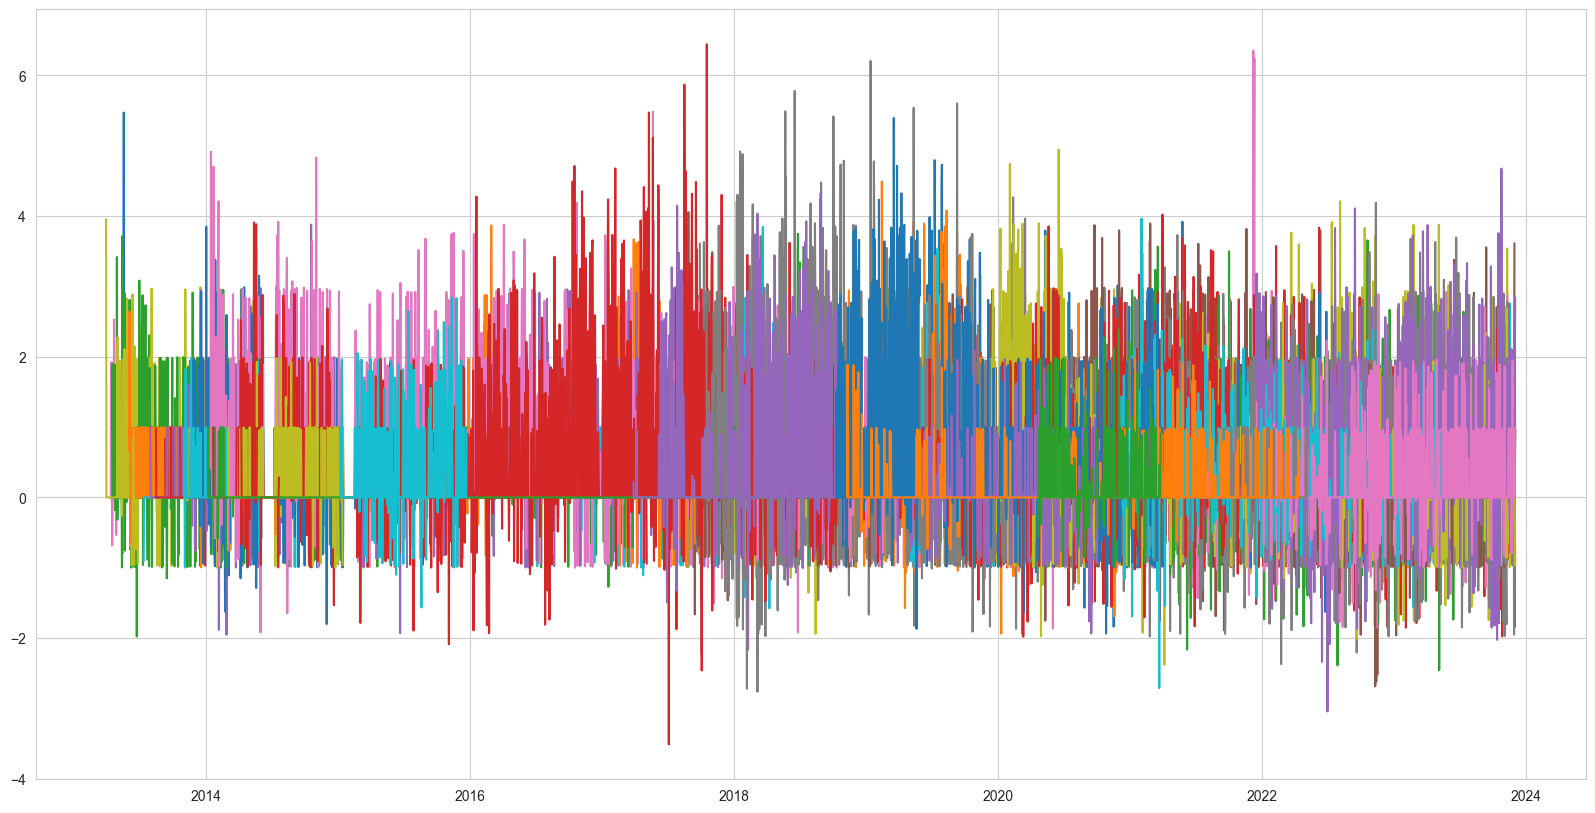

In [16]:
plt.figure(figsize=(20,10))

means = []
stds = []
for autor in autores:
    mask_autor = df_clean['author'] == autor
    df_author = df_clean.loc[mask_autor,['author', 'sentiment']]
    df_author = article_formatter.ResampleDF(df_author[['sentiment']], '1D')
    means.append(df_author['sentiment'].mean())
    stds.append(df_author['sentiment'].std())
    print('{}, sentimiento = {:.2f}+-{:.2f}'.format(autor, df_author['sentiment'].mean(), df_author['sentiment'].std()))
    
    plt.plot(df_author['sentiment'], label=autor)
    
plt.show()

In [17]:
df_clean.groupby('author').agg(np.count_nonzero)

,id,url,title,content,sentiment
author,,,,,
Deirdra Funcheon,7,7,7,7,7
Aaron Stanley,58,58,58,58,57
Aaron van Wirdum,7,7,7,6,6
Ada Hui,30,30,30,30,29
Adam B. Levine,180,180,180,177,161
...,...,...,...,...,...
Yao Qian,1,1,1,1,1
Yessi Bello Perez,318,318,318,317,315
Yogita Khatri,542,542,542,541,538


In [18]:
# Convertir a df
dict_author = {'author': autores, 'mean_sentiment': means, 'std_sentiment': stds}
df_authors = pd.DataFrame(dict_author)

# Ver el sesgo de cada autor,
# Neutral: [-0.5, 0.5]
# Positivo: > 0.5
# Negativo: < -0.5
def sesgo(x):
    if x > 0.5:
        return 'Positivo' 
    elif x < -0.5:
        return 'Negativo'
    else:
        return 'Neutral'
    
df_authors['sesgo'] = df_authors['mean_sentiment'].apply(lambda x: sesgo(x))
df_authors.groupby('sesgo').agg(np.count_nonzero)

,author,mean_sentiment,std_sentiment
sesgo,,,
Negativo,14,14,14
Neutral,233,232,232
Positivo,176,176,176


Vemos como la mayoria de los autores tienen un sesgo que podemos considerar neutral (233/423), seguido con sesgo positivo (176/423) y solo 14 (que es muy poco) con sesgo negativo.

# Interfaz Gradio para ver la evolución de las anomalias

In [216]:
anomalias = df_sum[(df_sum['positive_anomalie_index']==1)|(df_sum['negative_anomalie_index']==1)]
#anomalias[['positive_anomalie_index', 'negative_anomalie_index', 'rolling_zscore_sentiment']]

In [217]:
# Creamos un df copia del subconjunto del df_ohlcv desde ini_fecha hasta fin_fecha
ini_fecha = anomalias.index[0] - pd.Timedelta(days=14)
fin_fecha = anomalias.index[anomalias.shape[0] - 1] + pd.Timedelta(days=14)
df_returns_strategy = df_ohlcv.loc[ini_fecha:fin_fecha].copy()

# Creamos una nueva columna de log_returns_strategy
df_returns_strategy.loc[:, 'log_returns_strategy'] = 0.0

# Recorremos las anomalias enumerandolas para extraer el indice y el valor de la anomalia
for i, date in enumerate(anomalias.index):
    # Calculo el inicio de la operacion y el signo segun la anomalia
    inicio_operacion = date + pd.Timedelta(days=1)
    signo_anomalia = np.sign(anomalias.iloc[i]['rolling_zscore_sentiment'])
    
    # Determino el final_operacion a la fecha mas proxima entre 7 dias después de la anomalia y la 
    # anomalia siguiente, siempre que la anomalia no sea la ultima en cuyo caso no habrá proxima anomalia
    final_operacion = min(date + pd.Timedelta(days=7), 
                          anomalias.index[i+1] if date < anomalias.index[anomalias.shape[0] - 1] 
                          else date + pd.Timedelta(days=7))
    
    # Calculamos los retornos de la operacion y sumamos los retornos que hay 
    retornos_sum = df_returns_strategy.loc[inicio_operacion:final_operacion, 'log_returns']
    
    # Añado los retornos*signo (ya que compra suman y en venta restan) al df_returns_strategy 
    df_returns_strategy.loc[inicio_operacion:final_operacion,'log_returns_strategy'] = retornos_sum * signo_anomalia
                          
# Añadimos una columna de los retornos acumulados, los retornos lineales y los porcentuales
df_returns_strategy['cum_log_returns_strategy']= df_returns_strategy['log_returns_strategy'].cumsum()
df_returns_strategy['returns_strategy_lineales']= (np.exp(df_returns_strategy['cum_log_returns_strategy']) - 1.0)
df_returns_strategy['returns_strategy_porcentuales']= (np.exp(df_returns_strategy['cum_log_returns_strategy']) - 1.0)*100

# Vemos el final del df
# df_returns_strategy.head(33)     

In [218]:
horizon = 14
fecha = anomalias.index[0]
index_ini = fecha - pd.Timedelta(days=horizon)
index_fin = fecha + pd.Timedelta(days=horizon)

# Creamos un df retornos_hold como copia de un subconjunto de df_ohlcv
retornos_hold = df_ohlcv.loc[index_ini:,['close', 'open']].copy()

# Se crean la columna log_returns y se rellena en el df (inplace=True) el elemento Na por 0
retornos_hold['log_returns'] = np.log(retornos_hold['close']/retornos_hold['close'].shift(1))
retornos_hold.fillna(0, inplace=True)

# Se crean las columnas retornos_hold, retornos_hold_lineales y retornos_hold_porcentuales
retornos_hold['retornos_hold'] = retornos_hold['log_returns'].cumsum()
retornos_hold['retornos_hold_lineales'] = (np.exp(retornos_hold['retornos_hold']) - 1.0)
retornos_hold['retornos_hold_porcentuales'] = (np.exp(retornos_hold['retornos_hold']) - 1.0)*100
#retornos_hold 

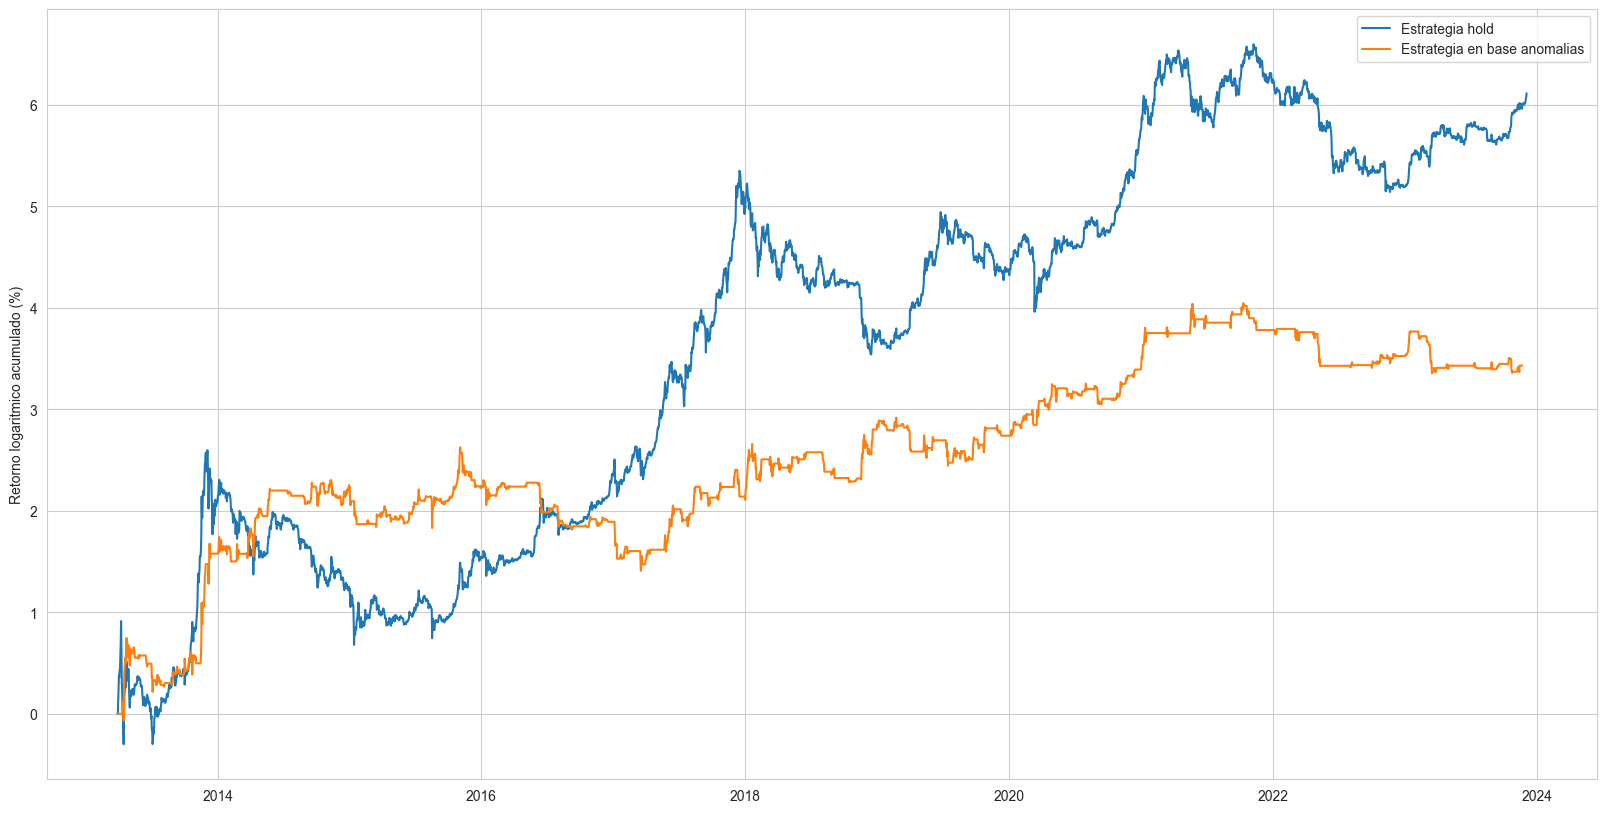

In [213]:
# Grafico para ver la diferencia entre los retornos de la estrategia y los retornos hold
plt.figure(figsize=(20, 10))
plt.plot(retornos_hold['retornos_hold'], label='Estrategia hold')
plt.plot(df_returns_strategy['cum_log_returns_strategy'], label='Estrategia en base anomalias')
plt.legend()
plt.ylabel('Retorno logaritmico acumulado (%)')
plt.show()

In [276]:
# Defino el indice global para iterar las anomalias
global index
index = -1

def convert_nummonth_to_text(nmonth):
    # Convertir el nmonth a entero para usarlo en los if
    month_number = int(nmonth)
    
    # Checkear en que caso estamos
    if month_number == 1:
        return 'Enero'
    elif month_number == 2:
        return 'Febrero'
    elif month_number == 3:
        return 'Marzo'
    elif month_number == 4:
        return 'Abril'
    elif month_number == 5:
        return 'Mayo'
    elif month_number == 6:
        return 'Junio'
    elif month_number == 7:
        return 'Julio'
    elif month_number == 8:
        return 'Agosto'
    elif month_number == 9:
        return 'Septiembre'
    elif month_number == 10:
        return 'Octubre'
    elif month_number == 11:
        return 'Noviembre'
    elif month_number == 12:
        return 'Diciembre'

def convert_fecha_to_text(fecha):
    # Pasar fecha a string
    fecha_string = str(fecha)
    
    # Dividir la fecha al espacio en blanco
    fecha_string = fecha_string.split(' ')
    
    # Split de la fecha a partir del primer elemento de fecha_string
    fecha_split = fecha_string[0].split('-')
    
    # Obtener el nombre del mes 
    month_text = convert_nummonth_to_text(fecha_split[1])
    
    # Crear el Mensaje y return del mismo
    message = str(fecha_split[2]) + ' de ' + month_text + ' del ' + str(fecha_split[0])
    return message

def convert_sign_to_text(sentimiento):
    # Calculamos el signo
    signo = np.sign(sentimiento)
    
    # Checkeamos el signo
    if signo == -1:
        # El signo es negativo
        return 'Negativa'   
    else:
        # El signo es positivo
        return 'Positiva' 
    
def get_next_anomaly_index(plot_type):
    # Cambiar el indice global index
    global index
    index = index + 1
       
    # Generamos el dataset de las anomalias, juntamos los casos de anomalia positiva y negativa
    anomalias = df_sum[(df_sum['positive_anomalie_index']==1)|(df_sum['negative_anomalie_index']==1)]
    
    # Obtenemos la fecha de la anomalia y el signo del sentimiento para decir si la anomalia 
    # es positiva o negativa
    anomaly_date = anomalias.iloc[index].name
   
    # sentiment_anomaly = np.sign(anomalias.iloc[index].rolling_zscore_sentiment)
    sentiment_anomaly = anomalias.iloc[index].rolling_zscore_sentiment
    
    # Pasamos la informacion como input a una función que plotea las cotizaciones en estas fechas
    return plot_anomaly_subplots(anomaly_date, sentiment_anomaly, plot_type)

def get_prev_anomaly_index(plot_type):
    # Cambiar el indice global index
    global index
    index = index - 1
       
    # Generamos el dataset de las anomalias, juntamos los casos de anomalia positiva y negativa
    anomalias = df_sum[(df_sum['positive_anomalie_index']==1)|(df_sum['negative_anomalie_index']==1)]
    
    # Obtenemos la fecha de la anomalia y el signo del sentimiento para decir si la anomalia 
    # es positiva o negativa
    anomaly_date = anomalias.iloc[index].name
   
    # sentiment_anomaly = np.sign(anomalias.iloc[index].rolling_zscore_sentiment)
    sentiment_anomaly = anomalias.iloc[index].rolling_zscore_sentiment
    
    # Pasamos la informacion como input a una función que plotea las cotizaciones en estas fechas
    return plot_anomaly_subplots(anomaly_date, sentiment_anomaly, plot_type)

def plot_anomaly_subplots(fecha, sentimiento_anomalia, plot_type):
    # Generamos la grafica de velas + la localizacion de la anomalia
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
    
    # Grafico de velas 
    horizon = 14
    index_ini = fecha - pd.Timedelta(days=horizon)
    index_fin = fecha + pd.Timedelta(days=horizon)
    local_ohlcv = df_ohlcv.loc[index_ini:index_fin]
    fig.add_trace(go.Candlestick(
        x=local_ohlcv.index,
        open=local_ohlcv['open'],
        high=local_ohlcv['high'],
        low=local_ohlcv['low'],
        close=local_ohlcv['close'],
        name='OHLCV'), row=1, col=1)
    
    # Añadir la localización de la anomalia con un color según su sentimiento
    fig.add_trace(go.Scatter(
        x=[fecha],
        y=[local_ohlcv.loc[fecha, 'close']],
        text=[sentimiento_anomalia],
        mode='markers',
        marker=dict(
            color= 'green' if sentimiento_anomalia > 0 else 'red',
            size=10,
            symbol='circle',
            line=dict(
                width=2,
                color='#00FFFF'
            )
        ),
        name='Anomalia'), row=1, col=1)
    # Añadir la evolución de los retornos logaritmicos de la estrategia
    fechas = pd.date_range(start=index_ini, end=index_fin, freq='D')
    
    # Cambiar los ejes segun el plot_type
    if plot_type == 'Logaritmico':
        fig.add_trace(go.Line(
            x=fechas,
            y=df_returns_strategy.loc[index_ini:index_fin, 'cum_log_returns_strategy'],
            name='Strategy'), row=2, col=1)
        
        fig.add_trace(go.Line(
            x=fechas,
            y=retornos_hold.loc[index_ini:index_fin, 'retornos_hold'],
            name='Hold'), row=2, col=1)
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Precio ($)', row=1, col=1)
        fig.update_yaxes(title_text='Retornos (log)', row=2, col=1)
        fig.update_xaxes(title_text='Fecha', row=2, col=1)
        fig.update_layout(title_text='Sentiment buys', title_font_size=20, xaxis_rangeslider_visible=False,
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
        
    elif plot_type == 'Lineal':
        fig.add_trace(go.Line(
            x=fechas,
            y=df_returns_strategy.loc[index_ini:index_fin, 'returns_strategy_lineales'],
            name='Strategy'), row=2, col=1)
        
        fig.add_trace(go.Line(
            x=fechas,
            y=retornos_hold.loc[index_ini:index_fin, 'retornos_hold_lineales'],
            name='Hold'), row=2, col=1)
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Precio ($)', row=1, col=1)
        fig.update_yaxes(title_text='Retornos (lin)', row=2, col=1)
        fig.update_xaxes(title_text='Fecha', row=2, col=1)
        fig.update_layout(title_text='Sentiment buys', title_font_size=20, xaxis_rangeslider_visible=False,
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
        
    elif plot_type == 'Porcentual':
        fig.add_trace(go.Line(
            x=fechas,
            y=df_returns_strategy.loc[index_ini:index_fin, 'returns_strategy_porcentuales'],
            name='Strategy'), row=2, col=1)
        
        fig.add_trace(go.Line(
            x=fechas,
            y=retornos_hold.loc[index_ini:index_fin, 'retornos_hold_porcentuales'],
            name='Hold'), row=2, col=1)
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Precio ($)', row=1, col=1)
        fig.update_yaxes(title_text='Retornos (%)', row=2, col=1)
        fig.update_xaxes(title_text='Fecha', row=2, col=1)
        fig.update_layout(title_text='Sentiment Buys', title_font_size=20, xaxis_rangeslider_visible=False,
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
     
    # Retornamos la figura
    return fig, convert_fecha_to_text(fecha), convert_sign_to_text(sentimiento_anomalia)

def plot_fullstrategy_and_hold(plot_type):
    # Defino el grafico
    fig = go.Figure()
    
    # Defino Fechas
    fechas = df_returns_strategy.index
    
    # Checkear el tipo de plot_type
    if plot_type == 'Logaritmico':
        fig.add_trace(go.Scatter(
            x=fechas,
            y=df_returns_strategy['cum_log_returns_strategy'],
            mode='lines',
            line=dict(color='seagreen'),
            name='Strategy'))
        
        fig.add_trace(go.Scatter(
            x=fechas,
            y=retornos_hold['retornos_hold'],
            mode='lines',
            line=dict(color='blueviolet'),
            name='Hold'))
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Retornos (log)')
        fig.update_xaxes(title_text='Fecha')
        fig.update_layout(title_text='Strategy vs Hold', title_font_size=20, xaxis_rangeslider_visible=False,
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
        
    elif plot_type == 'Lineal':
        fig.add_trace(go.Scatter(
            x=fechas,
            y=df_returns_strategy['returns_strategy_lineales'],
            mode='lines',
            line=dict(color='seagreen'),
            name='Strategy'))
        
        fig.add_trace(go.Scatter(
            x=fechas,
            y=retornos_hold['retornos_hold_lineales'],
            mode='lines',
            line=dict(color='blueviolet'),
            name='Hold'))
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Retornos (lin)')
        fig.update_xaxes(title_text='Fecha')
        fig.update_layout(title_text='Strategy vs Hold', title_font_size=20, xaxis_rangeslider_visible=False, 
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
        
    elif plot_type == 'Porcentual':
        fig.add_trace(go.Scatter(
            x=fechas,
            y=df_returns_strategy['returns_strategy_porcentuales'],
            mode='lines',
            line=dict(color='seagreen'),
            name='Strategy'))
        
        fig.add_trace(go.Scatter(
            x=fechas,
            y=retornos_hold['retornos_hold_porcentuales'],
            mode='lines',
            line=dict(color='blueviolet'),
            name='Hold'))
        
        # Cambiamos el texto de los ejes 
        fig.update_yaxes(title_text='Retornos (%)')
        fig.update_xaxes(title_text='Fecha')
        fig.update_layout(title_text='Strategy vs Hold', title_font_size=20, xaxis_rangeslider_visible=False,
                          legend=dict(
                              orientation="h",
                              yanchor="bottom",
                              y=1.02,
                              xanchor="right",
                              x=1)
                          )
     
    # Retornamos la figura
    return fig
    
# APP
with gr.Blocks() as demo:
    with gr.Tab("Anomalias Individuales"):
        # 1) Objeto Output de Radio
        radio = gr.Radio(['Logaritmico', 'Lineal', 'Porcentual'], value='Logaritmico',label='¿Que tipo de retornos mostrar?')
        
        # 2) Objetos Output de texto
        with gr.Row():
            output_text1 = gr.Text(label="Fecha de la Anomalia")
            output_text2 = gr.Text(label="Tipo de la Anomalia")
            
        # 3) Objeto Output de Plot
        output_plot = gr.Plot()
        
        # 4) Botones de siguiente y previo en una misma linea
        with gr.Row():
            button_prev = gr.Button(value="Previous")
            button_next = gr.Button(value="Next")
            
        # Acciones de los botones
        button_next.click(fn=get_next_anomaly_index, inputs=radio, outputs=[output_plot, output_text1, output_text2])
        button_prev.click(fn=get_prev_anomaly_index, inputs=radio, outputs=[output_plot, output_text1, output_text2])
        
    with gr.Tab("Resultado Global"):
        # 1) Fila con objeto radio y objeto columna con un texto y un boton 
        with gr.Row():
            radio = gr.Radio(['Logaritmico', 'Lineal', 'Porcentual'], 
                             value='Logaritmico',label='¿Que tipo de retornos mostrar?')
            
            with gr.Column():
                gr.Markdown("Realizar Gráfico:")
                button_launch = gr.Button(value="Plot")
            
        # 2) Objecto Plot
        output_plot2 = gr.Plot()
        
        # 3) Representar graficos dependiendo de radio
        button_launch.click(fn=plot_fullstrategy_and_hold, inputs=radio, outputs=[output_plot2])
        
demo.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


# Optimizar threshold y dias de mantenimiento

In [277]:
demo.close()

Closing server running on port: 7867


In [223]:
# Funciones 
def calcula_df_anomalias(df_sum, threshold):
    # Creamos un df copia de df_sum para no afectar sus columnas
    df_sum_copy = df_sum.copy()
    
    # Calculamos las columnas de ser anomalia positiva o negativa en base a threshold
    df_sum_copy['positive_anomalie_index'] = df_sum_copy['rolling_zscore_sentiment'].apply(lambda x: 1 if x > threshold else 0)
    df_sum_copy['negative_anomalie_index'] = df_sum_copy['rolling_zscore_sentiment'].apply(lambda x: 1 if x < -threshold else 0)
    
    # Calculamos el df con las anomalias
    anomalias = df_sum_copy[(df_sum_copy['positive_anomalie_index']==1)|(df_sum_copy['negative_anomalie_index']==1)]
    
    return anomalias

# Funcion que crea el df_returns
def calculate_df_returns(anomalias, df_ohlcv, maintain_days):
    # Creamos un df copia del subconjunto del df_ohlcv desde ini_fecha hasta fin_fecha
    ini_fecha = anomalias.index[0] - pd.Timedelta(days=14)
    fin_fecha = anomalias.index[anomalias.shape[0] - 1] + pd.Timedelta(days=14)
    df_returns_strategy = df_ohlcv.loc[ini_fecha:fin_fecha].copy()
    
    # Creamos una nueva columna de log_returns_strategy
    df_returns_strategy.loc[:, 'log_returns_strategy'] = 0.0
    
    # Recorremos las anomalias enumerandolas para extraer el indice y el valor de la anomalia
    for i, date in enumerate(anomalias.index):
        # Calculo el inicio de la operacion y el signo segun la anomalia
        inicio_operacion = date + pd.Timedelta(days=1)
        signo_anomalia = np.sign(anomalias.iloc[i]['rolling_zscore_sentiment'])
        
        # Determino el final_operacion a la fecha mas proxima entre 7 dias después de la anomalia y la 
        # anomalia siguiente, siempre que la anomalia no sea la ultima en cuyo caso no habrá proxima anomalia
        final_operacion = min(date + pd.Timedelta(days=maintain_days), 
                              anomalias.index[i+1] if date < anomalias.index[anomalias.shape[0] - 1] 
                              else date + pd.Timedelta(days=maintain_days))
        
        # Calculamos los retornos de la operacion y sumamos los retornos que hay 
        retornos_sum = df_returns_strategy.loc[inicio_operacion:final_operacion, 'log_returns']
        
        # Añado los retornos*signo (ya que compra suman y en venta restan) al df_returns_strategy 
        df_returns_strategy.loc[inicio_operacion:final_operacion,'log_returns_strategy'] = retornos_sum * signo_anomalia
                              
    # Añadimos una columna de los retornos acumulados, los retornos lineales y los porcentuales
    df_returns_strategy['cum_log_returns_strategy']= df_returns_strategy['log_returns_strategy'].cumsum()
    
    # Retornamos el df
    return df_returns_strategy

In [232]:
# Parametros de ejecución
thresholds = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2]
maintain_days = np.arange(1, 15, 1)

thresholds_loop = []
days_loop = []
returns = []
for threshold in thresholds:
    for day in maintain_days:
        # Calcular anomalias df
        anomalias = calcula_df_anomalias(df_sum, threshold)
        
        # Calcular df_return por las estrategias
        df_returns_strategy = calculate_df_returns(anomalias, df_ohlcv, day)
        
        # Obtener el retorno final
        indice_final = df_returns_strategy.shape[0] - 1
        fecha_final = df_returns_strategy.index[indice_final]
        final_return = df_returns_strategy.loc[fecha_final, 'cum_log_returns_strategy']
        thresholds_loop.append(threshold)
        days_loop.append(day)
        returns.append(final_return)
        
        print('Threshold = {} | Maintain_days = {} | Log_returns = {}'.format(threshold, day, final_return))

# Mostrar el mejor caso
max_return = max(returns)
indice_max = returns.index(max_return)
print('El retorno maximo = {} ocurre para Threshold = {} y maintain_days = {}'.format(max_return,
                                                                                      thresholds_loop[indice_max],
                                                                                      days_loop[indice_max]))

Threshold = 1.0 | Maintain_days = 1 | Log_returns = -0.6800806202161661
Threshold = 1.0 | Maintain_days = 2 | Log_returns = -2.1173003117338705
Threshold = 1.0 | Maintain_days = 3 | Log_returns = 0.23779172457376507
Threshold = 1.0 | Maintain_days = 4 | Log_returns = -0.6938706111759276
Threshold = 1.0 | Maintain_days = 5 | Log_returns = 0.2723080380335628
Threshold = 1.0 | Maintain_days = 6 | Log_returns = 0.21152461854304114
Threshold = 1.0 | Maintain_days = 7 | Log_returns = 0.44267480969665157
Threshold = 1.0 | Maintain_days = 8 | Log_returns = 0.07020698509216391
Threshold = 1.0 | Maintain_days = 9 | Log_returns = 0.09001279080299304
Threshold = 1.0 | Maintain_days = 10 | Log_returns = 0.11586222292825929
Threshold = 1.0 | Maintain_days = 11 | Log_returns = 0.26712302307335767
Threshold = 1.0 | Maintain_days = 12 | Log_returns = 0.31047596320610826
Threshold = 1.0 | Maintain_days = 13 | Log_returns = 0.35786418977913664
Threshold = 1.0 | Maintain_days = 14 | Log_returns = 0.430067

TypeError: 13 must be a sequence

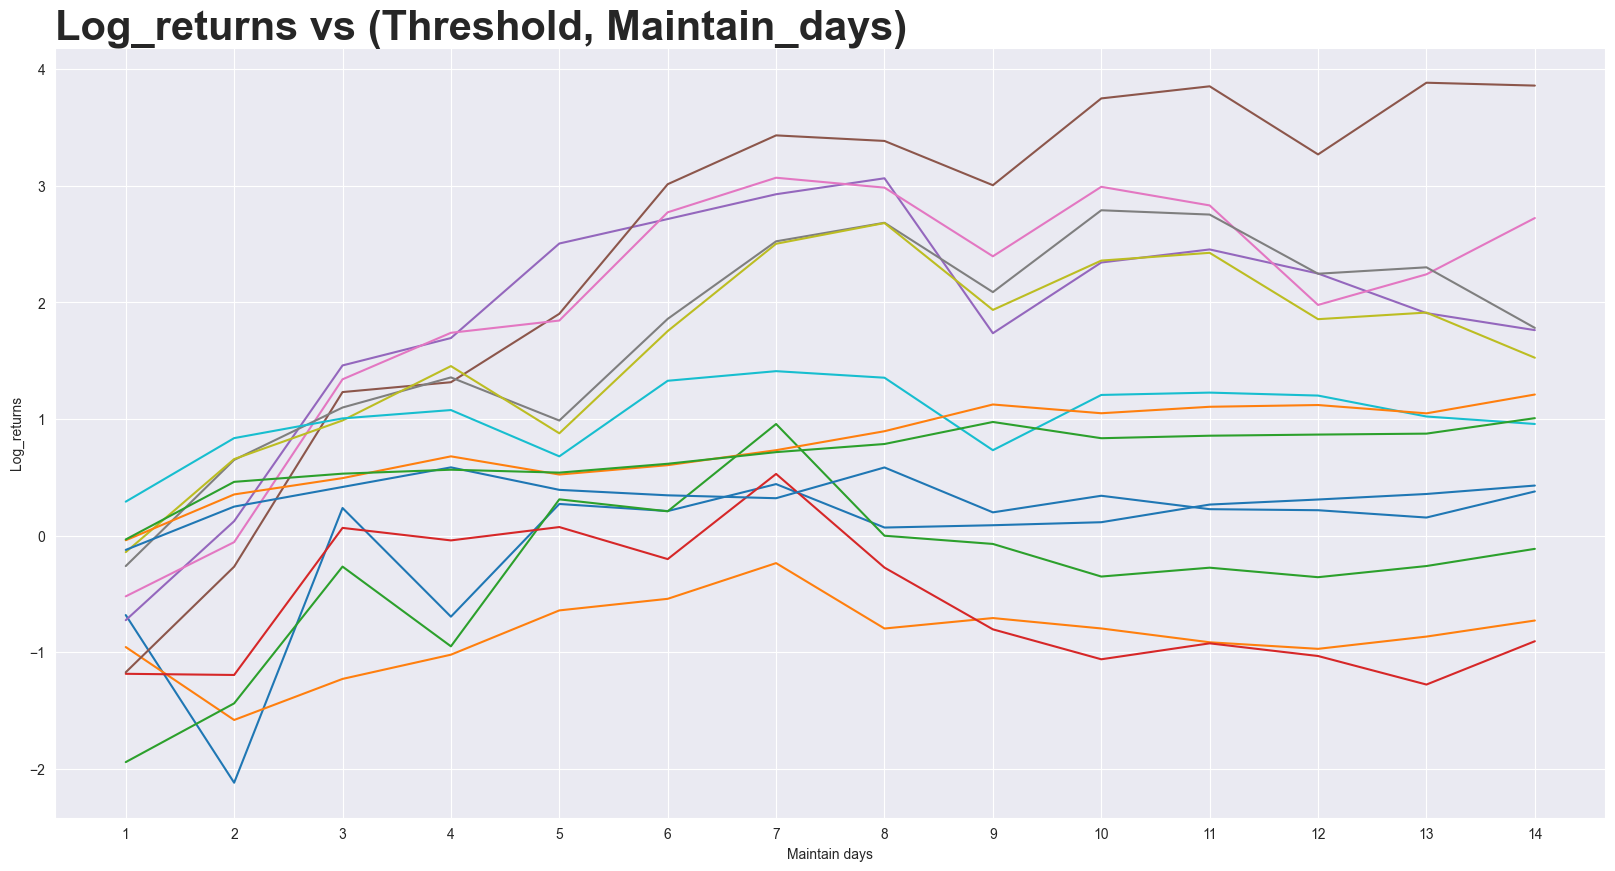

In [248]:
# Figura de la optimización
plt.figure(figsize=(20,10))

# Define the style
sns.set_style("darkgrid")

# Plotear curvas threshold en función del numero de dias
vector = np.array(returns)

# Divide vector 
last = len(thresholds)
segmentos = np.split(vector, last)

for i, segmento in enumerate(segmentos):
    plt.plot(np.arange(1, 15), segmento, label=f'Threshold = {thresholds[i]}')

plt.xlabel('Maintain days')
plt.ylabel('Log_returns')
plt.title('Log_returns vs (Threshold, Maintain_days)', loc='left', fontweight='bold', fontsize=30)
plt.xticks(np.arange(1, 15), maintain_days)
plt.legend()

plt.show()

In [251]:
# Tirar mas el hilo de los dias de mantenimiento con threshold = 1.5 fij
threshold = 1.5
days = np.arange(1, 32, 1)

new_returns = []
days_aux = []
for i, day in enumerate(days):
    # Calcular anomalias df
    anomalias = calcula_df_anomalias(df_sum, threshold)
    
    # Calcular df_return por las estrategias
    df_returns_strategy = calculate_df_returns(anomalias, df_ohlcv, day)
    
    # Obtener el retorno final
    indice_final = df_returns_strategy.shape[0] - 1
    fecha_final = df_returns_strategy.index[indice_final]
    final_return = df_returns_strategy.loc[fecha_final, 'cum_log_returns_strategy']

    new_returns.append(final_return)
    days_aux.append(day)
    print('Threshold = {} | Maintain_days = {} | Log_returns = {}'.format(threshold, day, final_return))

# Mostrar el mejor caso
max_return = max(new_returns)
indice_max = new_returns.index(max_return)
print('El retorno maximo = {} ocurre para Threshold = {} y maintain_days = {}'.format(max_return,
                                                                                      threshold,
                                                                                      days_aux[indice_max]))    

Threshold = 1.5 | Maintain_days = 1 | Log_returns = -1.1705219446587796
Threshold = 1.5 | Maintain_days = 2 | Log_returns = -0.26541906228844603
Threshold = 1.5 | Maintain_days = 3 | Log_returns = 1.2314955823787772
Threshold = 1.5 | Maintain_days = 4 | Log_returns = 1.31588267204295
Threshold = 1.5 | Maintain_days = 5 | Log_returns = 1.9025947601151814
Threshold = 1.5 | Maintain_days = 6 | Log_returns = 3.013393532154533
Threshold = 1.5 | Maintain_days = 7 | Log_returns = 3.431883115055076
Threshold = 1.5 | Maintain_days = 8 | Log_returns = 3.3842260653417435
Threshold = 1.5 | Maintain_days = 9 | Log_returns = 3.0047509418591845
Threshold = 1.5 | Maintain_days = 10 | Log_returns = 3.7487866932755187
Threshold = 1.5 | Maintain_days = 11 | Log_returns = 3.852599016466864
Threshold = 1.5 | Maintain_days = 12 | Log_returns = 3.268710292831788
Threshold = 1.5 | Maintain_days = 13 | Log_returns = 3.883308741418524
Threshold = 1.5 | Maintain_days = 14 | Log_returns = 3.8586729627430083
Thres

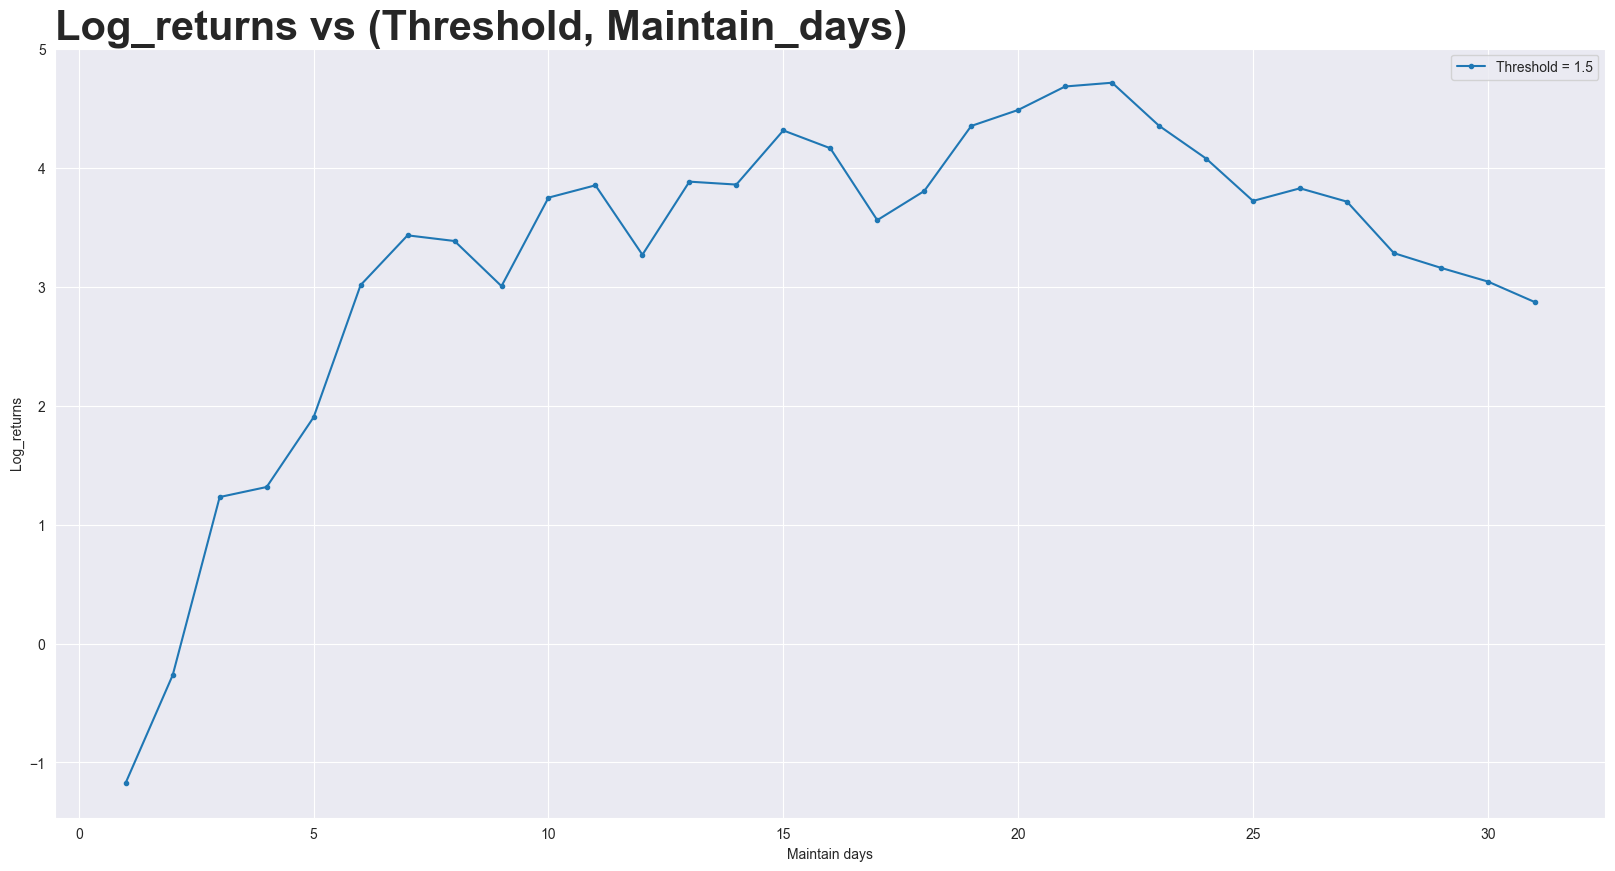

In [255]:
# Figura de la optimización
plt.figure(figsize=(20,10))

# Define the style
sns.set_style("darkgrid")

# Plotear curvas threshold en función del numero de dias
plt.plot(days, new_returns,'.-' ,label=f'Threshold = {threshold}')

plt.xlabel('Maintain days')
plt.ylabel('Log_returns')
plt.title('Log_returns vs (Threshold, Maintain_days)', loc='left', fontweight='bold', fontsize=30)
plt.legend()

plt.show()

El mejor  caso es manteniendo 22 dias las operaciones, siendo el maximo absoluto ya que a más días se produce un descenso pronunciado

# Crear los retornos y anomalias con los valores optimos

In [256]:
# Parametros
threshold = 1.5
maintain_days = days_aux[indice_max]

# Calcular anomalias df
anomalias = calcula_df_anomalias(df_sum, threshold)

# Calcular df_return por las estrategias
df_returns_strategy = calculate_df_returns(anomalias, df_ohlcv, maintain_days)

# Calcular el resto de columnas
df_returns_strategy['returns_strategy_lineales']= (np.exp(df_returns_strategy['cum_log_returns_strategy']) - 1.0)
df_returns_strategy['returns_strategy_porcentuales']= (np.exp(df_returns_strategy['cum_log_returns_strategy']) - 1.0)*100